## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport hapclust

In [2]:
# load data
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [3]:
# chop into gene
loc_vgsc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haps[loc_vgsc]
pos_vgsc = pos[loc_vgsc]

h_vgsc

<HaplotypeArray shape=(1713, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [4]:
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))[ :-16]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])

In [5]:
df_haplotypes = tbl_haplotypes.todataframe(index='index')
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [6]:
# make an array of original haplotype indices, we'll need this later on to help
# figure out cluster concordances
hap_ixs = np.arange(len(df_haplotypes))
hap_ixs

array([   0,    1,    2, ..., 1543, 1544, 1545])

In [7]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
#     .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [8]:
len(tbl_variant_labels)

7279

In [9]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')

In [10]:
pos2label[2358254], len(pos_vgsc)

('D33N', 1713)

In [11]:
variant_labels = np.array([pos2label.get(p, '') for p in pos_vgsc], dtype=object)
# variant_labels_vgsc = variant_labels[loc]
# variant_labels_vgsc[:5]
variant_labels[:5]

array(['D33N', '', '', '', ''], dtype=object)

In [12]:
pos_vgsc

0,1,2,3,4,...,1708,1709,1710,1711,1712
2358254,2358316,2358328,2358353,2358405,...,2431417,2431487,2431518,2431527,2431542


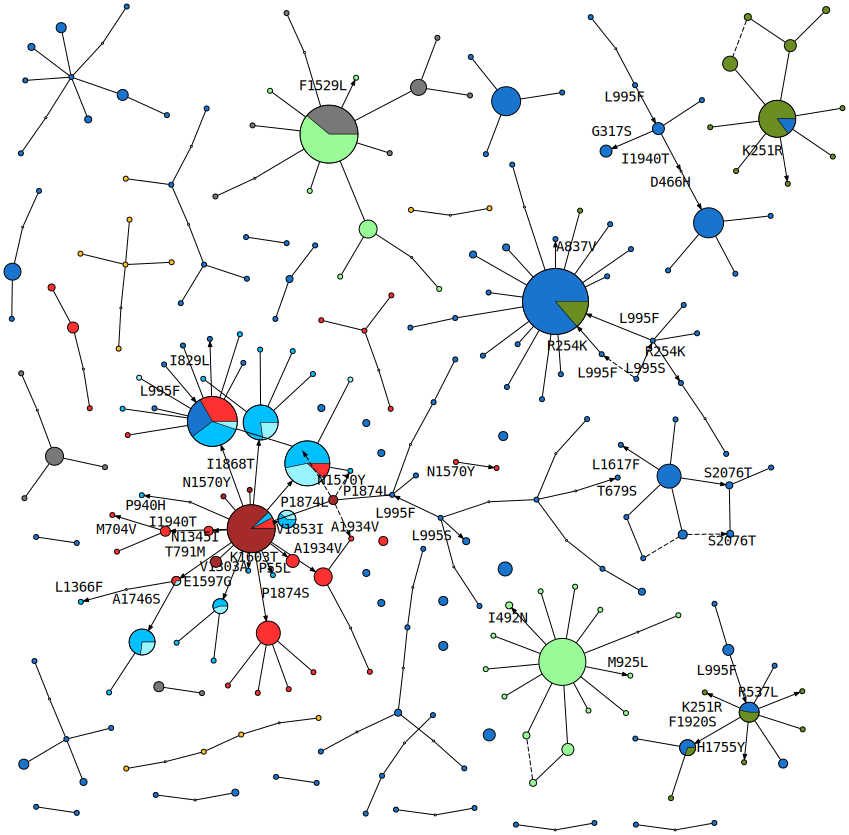

In [13]:
# check network construction works
graph, _ = hapclust.graph_haplotype_network(
    h_vgsc, 
    network_method='msn', 
    hap_colors=hap_colors, 
    max_dist= 2, 
    variant_labels=variant_labels,
    show_singletons=False)
graph

In [14]:
pos_995S = 2422651
pos_995F = 2422652
pos_1527 = 2429617

In [15]:
loc_995S = h_vgsc[pos_vgsc.locate_key(pos_995S)] == 1
loc_995F = h_vgsc[pos_vgsc.locate_key(pos_995F)] == 1
loc_1527 = h_vgsc[pos_vgsc.locate_key(pos_1527)] == 1

In [16]:
loc_995F

array([ True,  True, False, ...,  True,  True,  True], dtype=bool)

In [17]:
pop_995F = df_haplotypes.population[:h_vgsc.shape[1]].iloc[loc_995F]
pop_995F.head()

index
0    BFS
1    BFS
3    BFM
4    BFM
5    BFM
Name: population, dtype: object

In [18]:
pop_995F.value_counts()

CMS    291
BFS    162
BFM    117
AOM    103
GNS     62
GAS     40
Name: population, dtype: int64

In [19]:
pop_995S = df_haplotypes.population[:h_vgsc.shape[1]].iloc[loc_995S]
pop_995S.head()

index
300    UGS
301    UGS
302    UGS
303    UGS
304    UGS
Name: population, dtype: object

In [20]:
pop_995S.value_counts()

UGS    206
CMS     85
GAS     72
KES     67
Name: population, dtype: int64

In [21]:
pop_1527 = df_haplotypes.population[:h_vgsc.shape[1]].iloc[loc_1527]
pop_1527.value_counts()

BFM    19
Name: population, dtype: int64

In [22]:
np.count_nonzero(loc_995F), np.count_nonzero(loc_995S), np.count_nonzero(loc_1527)

(775, 430, 19)

In [23]:
# kdr haps
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
h_vgsc_1527 = h_vgsc.compress(loc_1527, axis=1)

In [24]:
# colours
hap_colors_995F = hap_colors.compress(loc_995F)
hap_colors_995S = hap_colors.compress(loc_995S)
hap_colors_1527 = hap_colors.compress(loc_1527)

In [25]:
# original haplotype indices - will need these for cluster correspondence
hap_ixs_995F = hap_ixs.compress(loc_995F)
hap_ixs_995S = hap_ixs.compress(loc_995S)
hap_ixs_1527 = hap_ixs.compress(loc_1527)

## L995F networks

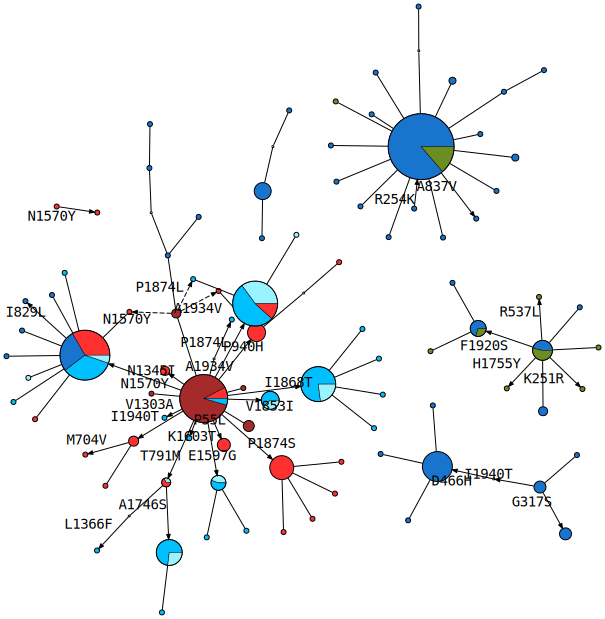

In [26]:
graph_995F, h_distinct_sets_995F, components_995F = hapclust.graph_haplotype_network(
    h_vgsc_995F, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995F, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)

graph_995F.format = 'svg'
fn = '../artwork/995F_clusters_mjn_maxdist2'
graph_995F.render(fn)
graph_995F

In [27]:
# this tells you, for each *distinct* haplotype (i.e., node in the graph), 
# which "connected component" (i.e., cluster) it belongs to
components_995F

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  2,  0,  0,  0,
        0,  0,  3,  4,  0,  5,  0,  0,  6,  7,  0,  8,  0,  9,  9, 10,  8,
        8, 10,  9, 10,  0, 10,  8,  8, 11, 12,  8, 13, 14,  9, 15,  8, 10,
       16, 17,  8, 11,  8, 18,  8,  0,  0,  0,  0,  8,  8,  8,  9,  8, 19,
       11, 20,  9,  8, 21,  9,  0, 22,  8, 23,  0,  8,  0,  0, 24, 25, 26,
       27,  0,  0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 10,  8, 10, 10,
       10, 10,  0,  0], dtype=int32)

In [28]:
# this tells you the number of distinct haplotypes for each connected component
# e.g., component 0 has 51 *distinct* haplotypes (= 51 nodes in the graph)
# e.g., component 8 has 18 *distinct* haplotypes (= 18 nodes in the graph)
np.bincount(components_995F)

array([51,  1,  2,  1,  1,  1,  1,  1, 18,  7, 10,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [29]:
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network.
    It is designed to warp your mind."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

In [30]:
network_clusters_995F = identify_components(h_distinct_sets_995F, components_995F)
len(network_clusters_995F)

38

In [31]:
len(network_clusters_995F[0])

456

In [32]:
hierarchical_cluster_membership = np.load('../data/vgsc_cluster_membership.npy').astype('U')
hierarchical_clusters = {('wt' if not k else k): set(np.nonzero(hierarchical_cluster_membership == k)[0]) 
                         for k in np.unique(hierarchical_cluster_membership)}
for k in sorted(hierarchical_clusters):
    print(repr(k), len(hierarchical_clusters[k]))

'F1' 464
'F2' 14
'F3' 42
'F4' 38
'F5' 196
'S1' 108
'S2' 79
'S3' 165
'S4' 37
'S5' 36
'wt' 351


In [33]:
len(hierarchical_clusters['F1'])

464

In [34]:
# setup to quantify overall concordance
network_cluster_membership = np.full_like(hierarchical_cluster_membership, fill_value='')

In [35]:
def find_concordance_995F(nc_ix, hc):
    
    # network cluster, mapped back to original haplotype indices
    network_cluster = set(hap_ixs_995F.take(network_clusters_995F[nc_ix]))
    
    # find intersection
    hierarchical_cluster = hierarchical_clusters[hc]
    n_isec = len(hierarchical_cluster.intersection(network_cluster))

    # outputs
    print(repr(hc), n_isec, len(hierarchical_cluster), len(network_cluster), 
          '{:.1f}% concordance'.format(n_isec * 100 / len(hierarchical_cluster)))
    
    # assign
    network_cluster_membership[list(network_cluster)] = hc

In [36]:
for i, l in enumerate(network_clusters_995F):
    if len(l) > 2:
        print(i, len(l))

0 456
8 187
9 50
10 35
11 13


In [37]:
pop_995F.iloc[network_clusters_995F[0]].value_counts()

BFS    161
BFM    110
AOM     89
GNS     62
CMS     34
Name: population, dtype: int64

In [38]:
find_concordance_995F(0, 'F1')

'F1' 456 464 456 98.3% concordance


In [39]:
pop_995F.iloc[network_clusters_995F[8]].value_counts()

CMS    163
GAS     24
Name: population, dtype: int64

In [40]:
find_concordance_995F(8, 'F5')

'F5' 187 196 187 95.4% concordance


In [41]:
find_concordance_995F(9, 'F4')

'F4' 37 38 50 97.4% concordance


In [42]:
find_concordance_995F(10, 'F3')

'F3' 35 42 35 83.3% concordance


In [43]:
find_concordance_995F(11, 'F2')

'F2' 13 14 13 92.9% concordance


In [44]:
len(network_clusters_995F)

38

In [45]:
max(network_clusters_995F[12])

346

In [46]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]
is_accessible

array([False, False, False, ..., False, False, False], dtype=bool)

In [47]:
is_accessible_vgsc = is_accessible[region_vgsc.loc0]
n_bp_accessible_vgsc = np.count_nonzero(is_accessible_vgsc)
n_bp_accessible_vgsc

32966

In [48]:
def compute_pi_995F():
    for i, s in enumerate(network_clusters_995F):
        if len(s) >= 3:
            h = h_vgsc_995F.take(s, axis=1)
            ac = h.count_alleles(max_allele=1)
            mpd = allel.mean_pairwise_difference(ac)
            pi = np.sum(mpd) / n_bp_accessible_vgsc
            print(i, pi)
            
compute_pi_995F()

0 5.09568598062e-05
8 6.80258218903e-06
9 3.52125318974e-05
10 3.10990136514e-05
11 1.40004386804e-05


## L995S networks

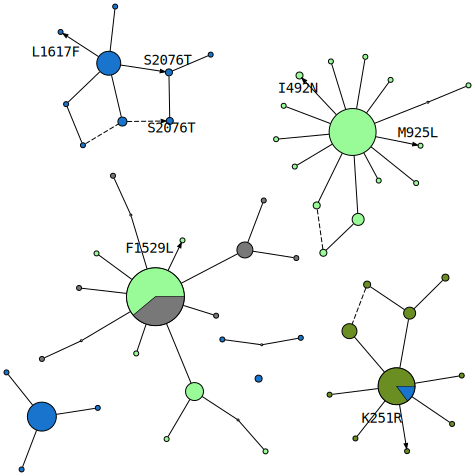

In [49]:
graph_995S, h_distinct_sets_995S, components_995S = hapclust.graph_haplotype_network(
    h_vgsc_995S, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995S, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)

graph_995S.format = 'svg'
fn = '../artwork/995S_clusters_mjn_maxdist2'
graph_995S.render(fn)
graph_995S

In [50]:
network_clusters_995S = identify_components(h_distinct_sets_995S, components_995S)
for i, l in enumerate(network_clusters_995S):
    if len(l) > 2:
        print(i, len(l))

0 107
1 165
3 36
5 34
8 78


In [51]:
def find_concordance_995S(nc_ix, hc):
    
    # network cluster, mapped back to original haplotype indices
    network_cluster = set(hap_ixs_995S.take(network_clusters_995S[nc_ix]))
    
    # find intersection
    hierarchical_cluster = hierarchical_clusters[hc]
    n_isec = len(hierarchical_cluster.intersection(network_cluster))

    # outputs
    print(repr(hc), n_isec, len(hierarchical_cluster), len(network_cluster), 
          '{:.1f}% concordance'.format(n_isec * 100 / len(hierarchical_cluster)))
    
    # assign
    network_cluster_membership[list(network_cluster)] = hc

In [52]:
find_concordance_995S(0, 'S1')

'S1' 107 108 107 99.1% concordance


In [53]:
find_concordance_995S(1, 'S3')

'S3' 165 165 165 100.0% concordance


In [54]:
find_concordance_995S(3, 'S4')

'S4' 36 37 36 97.3% concordance


In [55]:
find_concordance_995S(5, 'S5')

'S5' 34 36 34 94.4% concordance


In [56]:
find_concordance_995S(8, 'S2')

'S2' 78 79 78 98.7% concordance


In [57]:
# overall concordance
np.count_nonzero(hierarchical_cluster_membership == network_cluster_membership) * 100 / len(hierarchical_cluster_membership)

97.12418300653594

In [58]:
def compute_pi_995S():
    for i, s in enumerate(network_clusters_995S):
        if len(s) >= 3:
            h = h_vgsc_995S.take(s, axis=1)
            ac = h.count_alleles(max_allele=1)
            mpd = allel.mean_pairwise_difference(ac)
            pi = np.sum(mpd) / n_bp_accessible_vgsc
            print(i, pi)
            
compute_pi_995S()

0 1.38004676818e-05
1 1.43084552298e-05
3 5.05571396793e-06
5 2.57381802004e-05
8 1.97379921945e-05


## I1527T

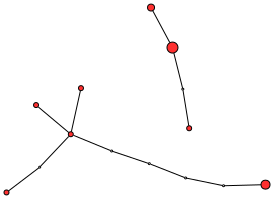

In [59]:
graph_1527, h_distinct_sets_1527, components_1527 = hapclust.graph_haplotype_network(
    h_vgsc_1527, 
    network_method='mjn', 
    max_dist=5, 
    hap_colors=hap_colors_1527, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)

graph_1527.format = 'svg'
fn = '../artwork/1527_clusters_mjn_maxdist2'
graph_1527.render(fn)

graph_1527

In [60]:
variant_labels[838]

'V402L'

In [61]:
network_clusters_1527 = identify_components(h_distinct_sets_1527, components_1527)
for i, l in enumerate(network_clusters_1527):
    if len(l) > 0:
        print(i, len(l))

0 8
1 7
2 1
3 1
4 1
5 1


In [62]:
h_vgsc_1527[838]

array([2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1], dtype=int8)

In [63]:
h_vgsc_1527[838, network_clusters_1527[0]]

array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [64]:
h_vgsc_1527[838, network_clusters_1527[1]]

array([1, 1, 1, 1, 1, 1, 1], dtype=int8)

So two separate networks, one for each of the two V402L alternate alleles.

## Wt diversity

In [65]:
def compute_wt_diversity(pop):

    loc_pop = (df_haplotypes.population == pop).values[:-16]
    loc_pop.shape

    h_vgsc_wt_pop = h_vgsc.compress(~loc_995S & ~loc_995F & ~loc_1527 & loc_pop, axis=1)

    ac = h_vgsc_wt_pop.count_alleles(max_allele=1)
    mpd = allel.mean_pairwise_difference(ac)
    pi = np.sum(mpd) / n_bp_accessible_vgsc

    return h_vgsc_wt_pop.shape, pi

In [66]:
compute_wt_diversity('CMS')

((1713, 174), 0.0013963001235142061)

In [67]:
compute_wt_diversity('GWA')

((1713, 92), 0.0057312520429987964)

In [68]:
compute_wt_diversity('BFM')

((1713, 3), 0.0031749883718578736)

In [69]:
compute_wt_diversity('AOM')

((1713, 17), 0.0028938014567593704)